In [1]:
import pymongo
import pandas as pd
from pymongo import MongoClient


import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [2]:
client = MongoClient()
db_nba= client.nba
collection = db_nba.player_stats
df_nba = pd.DataFrame(list(collection.find()))

Let's take a high-level look at our dataframe.

In [3]:
df_nba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13324 entries, 0 to 13323
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                13324 non-null  object 
 1   Player_ID          13324 non-null  int64  
 2   GROUP_SET          13324 non-null  object 
 3   GROUP_VALUE        13324 non-null  object 
 4   TEAM_ID            13324 non-null  int64  
 5   TEAM_ABBREVIATION  13324 non-null  object 
 6   MAX_GAME_DATE      13324 non-null  object 
 7   GP                 13324 non-null  int64  
 8   W                  13324 non-null  int64  
 9   L                  13324 non-null  int64  
 10  W_PCT              13324 non-null  float64
 11  MIN                13324 non-null  float64
 12  FGM                13324 non-null  int64  
 13  FGA                13324 non-null  int64  
 14  FG_PCT             13324 non-null  float64
 15  FG3M               13324 non-null  int64  
 16  FG3A               133

In taking a quick look, we can get rid of a handful of columns due to irrelevance or colinearity. 'GROUP_VALUE' should be renamed to 'season' as well. Lastly, for indexing ease, let's lower case all column names. 



In [4]:
df_nba.drop(columns = ['_id','GROUP_SET', 'MAX_GAME_DATE', 'W_PCT','MIN','NBA_FANTASY_PTS', 'DD2', 'TD3', 'CFID', 'CFPARAMS'], inplace = True)

In [5]:
df_nba.rename(columns={'GROUP_VALUE':'season'}, inplace = True)

In [6]:
d_lower = dict()
for i in df_nba.columns:
    d_lower[i] = i.lower()

df_nba.rename(columns=d_lower, inplace = True)
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

The last bit of preliminary cleaning will be to get rid of all entries for the 2019-20 season, as the season was stalled, so we won't have any target values. We can do this via indexing.

In [7]:
df_nba.drop(df_nba[df_nba['season'] == '2019-20'].index , inplace=True)

# We first want to investigate the predictivity of regular season wins and playoff berths based on a team roster's individual efficiency ratings from the prior year. 

There are a handful of efficiency metrics that are worth invesitgating here:

Martin Manley's Efficiency ('EFF'): ((Points + Rebounds + Assists + Steals + Blocks) - (Missed Field Goals + Missed Free Throws + Turnovers))/ Games Played

European Performance Index Rating ('PIR'): ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - (Missed Field Goals + Missed Free Throws + Turnovers + Shots Rejected + Fouls Committed))/ Games Played

Note: We will not be considering John Hollinger's Player Efficiency Rating ('PER'): It is the most frequently used alternative, however PER is derived by a very complex calculation designed to compensate for different teams' varying style of play, among other factors, and PER scores do not differ markedly from EFF scores.

This study is more so interested in an individual player's efficiency being predictive of team success, regardless of coaching and playing styles. Furthermore, looking at these raw statistics will help inform to what extent a coach should seek to opitimize all individual player efficiencies, or spend a majority of their time tending to star players, or perhaps optimizing other metrics via playing style.

# Let's calculate EFF and PIR's for each player on a per season basis. Then we'll aggregate team rosters on a yearly basis, to eventually offset one season's stats to be fit to the following season's results.

In [8]:
df_nba.columns

Index(['player_id', 'season', 'team_id', 'team_abbreviation', 'gp', 'w', 'l',
       'fgm', 'fga', 'fg_pct', 'fg3m', 'fg3a', 'fg3_pct', 'ftm', 'fta',
       'ft_pct', 'oreb', 'dreb', 'reb', 'ast', 'tov', 'stl', 'blk', 'blka',
       'pf', 'pfd', 'pts', 'plus_minus'],
      dtype='object')

In [9]:
"""EFF = ((Points + Rebounds + Assists + Steals + Blocks) - Missed Field Goals - Missed Free Throws - Turnovers))/ Games Played"""

df_nba['eff'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov']) / df_nba['gp']


"""PIR = ((Points + Rebounds + Assists + Steals + Blocks + Fouls Drawn) - Missed Field Goals - Missed Free Throws - Turnovers - Shots Rejected - Fouls Committed))/ Games Played"""
df_nba['pir'] = ((df_nba['pts']+ df_nba['reb']+df_nba['ast']+df_nba['stl']+df_nba['blk']+df_nba['pfd']) \
                 - (df_nba['fga']-df_nba['fgm']) \
                 - (df_nba['fta']-df_nba['ftm']) \
                 - df_nba['tov'] \
                 - df_nba['blka'] \
                 - df_nba['pf']) / df_nba['gp']

## Below are the results of our EFF and PIR calculations.

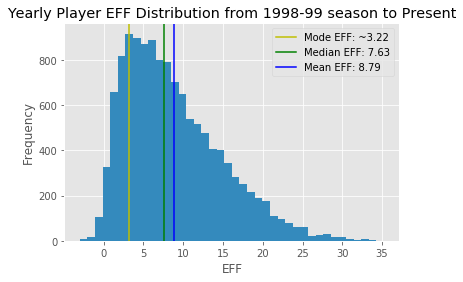

In [10]:
#Calculate all EFF averages and plot histogram to inform distribution

mean_eff = round(np.mean(df_nba['eff']),2)
median_eff = round(np.median(df_nba['eff']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['eff'], bins = 40)
ax.set_title('Yearly Player EFF Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['eff'], bins = 40)[0],ax.hist(df_nba['eff'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_eff = round(np.mean([upper,lower]),2)

ax.axvline(mode_eff, color = 'y', label = f'Mode EFF: ~{mode_eff}')
ax.axvline(median_eff, color = 'g', label = f'Median EFF: {median_eff}')
ax.axvline(mean_eff, color = 'b', label = f'Mean EFF: {mean_eff}')

ax.set_ylabel('Frequency')
ax.set_xlabel('EFF')
ax.legend()


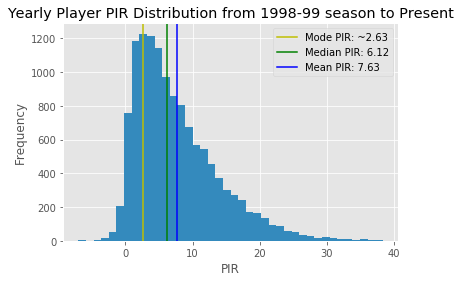

In [11]:
#Calculate all PIR averages and plot histogram to inform distribution

mean_pir = round(np.mean(df_nba['pir']), 2)
median_pir = round(np.median(df_nba['pir']),2)

fig, ax = plt. subplots()

# ax.hist(df_nba['pir'], bins = 40)
ax.set_title('Yearly Player PIR Distribution from 1998-99 season to Present')

# Index to highest frequency bin
counts, bins = ax.hist(df_nba['pir'], bins = 40)[0],ax.hist(df_nba['pir'], bins = 40)[1]

idx_max = np.argmax(counts)
upper = bins[idx_max+1]
lower = bins[idx_max]
mode_pir = round(np.mean([upper,lower]),2)

ax.axvline(mode_pir, color = 'y', label = f'Mode PIR: ~{mode_pir}')
ax.axvline(median_pir, color = 'g', label = f'Median PIR: {median_pir}')
ax.axvline(mean_pir, color = 'b', label = f'Mean PIR: {mean_pir}')

ax.set_ylabel('Frequency')
ax.set_xlabel('PIR')
ax.legend()


## Now let's group the data by teams, season, and efficiency to get all of our efficiencies scores in the right place. 

In [12]:
df_nba.groupby(['team_abbreviation','season','eff']).first()

player_id     team_id  gp   w   l  fgm  \
team_abbreviation season  eff                                                 
ATL               1996-97 2.000000         292  1610612737   1   0   1    0   
                          5.380282         695  1610612737  71  48  23  148   
                          5.913793         468  1610612737  58  38  20  100   
                          7.366667         673  1610612737  30  20  10   77   
                          10.385714        895  1610612737  70  49  21  253   
...                                        ...         ...  ..  ..  ..  ...   
WAS               2018-19 16.678571    1626171  1610612764  28  10  18  157   
                          16.888889       2730  1610612764   9   4   5   43   
                          17.360000     203953  1610612764  25  10  15  149   
                          20.468750     202322  1610612764  32  11  21  245   
                          24.170732     203078  1610612764  82  32  50  764   

                                      fga  fg_pct  fg3m  fg3a  ...  ast  tov  \
team_abbreviation season  eff                                  ...             
ATL               1996-97 2.000000      5   0.000     0     0  ...    0    0   
                          5.380282    350   0.423    58   140  ...   94   65   
                          5.913793    246   0.407    48   124  ...  115   59   
                          7.366667    162   0.475     0     0  ...   23   29   
                          10.385714   600   0.422    74   208  ...  124   85   
...                                   ...     ...   ...   ...  ...  ...  ...   
WAS               2018-19 16.678571   357   0.440    48   119  ...   43   45   
                          16.888889    69   0.623     0     0  ...    4   16   
                          17.360000   285   0.523    24    81  ...   68   67   
                          20.468750   552   0.444    51   169  ...  279  121   
                          24.170732  1609   0.475   209   596  ...  448  224   

                                     stl  blk  blka   pf  pfd   pts  \
team_abbreviation season  eff                                         
ATL               1996-97 2.000000     0    0     1    2    0     0   
                          5.380282    38    4    19   97    0   405   
                          5.913793    55    3     9   56    0   285   
                          7.366667    21    6    16   73    0   199   
                          10.385714   90    7    33  176    1   666   
...                                  ...  ...   ...  ...  ...   ...   
WAS               2018-19 16.678571   24   12    16   84   48   400   
                          16.888889    7    4     8   34   48   115   
                          17.360000   23   16    17   58   67   374   
                          20.468750   49   29    36   71  131   663   
                          24.170732  121   58    64  226  361  2099   

                                     plus_minus        pir  
team_abbreviation season  eff                               
ATL               1996-97 2.000000          -14  -1.000000  
                          5.380282          -37   3.746479  
                          5.913793          103   4.793103  
                          7.366667          -80   4.400000  
                          10.385714         417   7.414286  
...                                         ...        ...  
WAS               2018-19 16.678571          13  14.821429  
                          16.888889         -50  17.555556  
                          17.360000          20  17.040000  
                          20.468750        -152  21.218750  
                          24.170732        -112  25.036585  

[12722 rows x 27 columns]